## Crop Yield Prediction 

Aim: Predict crop yields for american crops for this year, based on current and historical images. 

### Requirements:
 <br>
 1. Map layers from the USDA that mark farmed land. <br>
 2. High frequency optical color data of the farmed land. <br>
 3. weather data that can be readily incorporated.  <br>

In [1]:
import ee

In [6]:
%%capture captured_output
ee.Authenticate()

Enter verification code: 4/1AeaYSHCPOJCIUf9puX2riwTWkkIYvsEDgpTa1u2AZfVMPu_H98IP_Adh7H0


In [7]:
ee.Initialize()

### 1. Map layers from the USDA 

In [8]:
import datetime
import geemap.core as geemap

In [9]:
%matplotlib notebook

# Initialize a map object.
m = geemap.Map()
center_coordinates = [-100, 40]
USDA_cropland = ee.ImageCollection("USDA/NASS/CDL").filterDate('2020-01-01', '2020-12-31').first()
m.add_layer(USDA_cropland, None, 'USDA CDL Layer')
m.centerObject(ee.Geometry.Point(center_coordinates), 4)
m

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

What we want to extract from this CDL layer is the cropland for corn. from the reference page on (https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL#bands) we can see that the code for corn is 1 and the associated color is #ffd300 (yellow). Lets visualize this. 

In [10]:
cropland_only = geemap.Map()
center_coordinates = [-100, 40]

# USDA CDL With layers 'cropland' detailing the types of crops, 'cultivated' (0 = uncultivated)
# confidence (0-100)

corn_farmland = USDA_cropland.select("cropland")

cropland_only.addLayer(corn_farmland,{},'cropland')
cropland_only.centerObject(ee.Geometry.Point(center_coordinates), 4)
cropland_only

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Lets also extract just the corn farmland from this data and create a mask. 

In [11]:

corn_only_map = geemap.Map()

center_coordinates = [-100, 40]

mask  = corn_farmland.eq(1)
#cornRegions = corn_farmland.updateMask(mask)

## 1.1 Producing training data 

To create a training dataset, we would have to first select a patch of land (or construct a polygon of coordinates) over which we have both CDL and Landsat coverage. Ordered by volume, the largest produces of corn are Iowa, Illinois and Nebraska. Lets select Iowa for our analysis.

In [12]:
all_states = ee.FeatureCollection('TIGER/2018/States')

# state code for nebraska is '31', Iowa is '19' and illinois is '17'
iowa_geometry = all_states.filter(ee.Filter.eq('STATEFP', '19')).geometry()

# Calculate the centroid coordinates of Iowa
centroid_coords = iowa_geometry.centroid().coordinates().getInfo()

# Create a bounding box around the centroid to ensure it covers the entire state
enlarged_iowa_bbox = ee.Geometry.Point(centroid_coords)

In [13]:
#loading in the landsat image 
image_from_landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
                        .filterBounds(enlarged_iowa_bbox)\
                        .filterDate('2020-01-01', '2020-12-31')\
                        .sort('CLOUD_COVER')\
                        .first()\
              
img_geo = image_from_landsat.geometry()

In [14]:
import numpy as np 


farm_vector = mask.reduceToVectors(
    geometry=img_geo,
    scale=100,# Choose an appropriate scale
    geometryType='centroid')

corn_points = farm_vector.geometry()

fifty_random_idxs = np.random.randint(0, len(corn_points.getInfo()['coordinates']),size=50)

coords = corn_points.getInfo()['coordinates']

random_coords = [ coords[i] for i in fifty_random_idxs ] 

points_random = [ee.Geometry.Point(i) for i in random_coords ]

In [15]:
start_date = ee.Date('2020-01-01')
end_date = ee.Date('2020-12-31')

In [16]:

landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
                        .filterBounds(enlarged_iowa_bbox)\
                        .filterDate(start_date, end_date)\
            

def add_ndvi(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return image.addBands(ndvi)


landsat_with_ndvi = landsat_collection.map(add_ndvi)

In [17]:

def get_medians(image):
    
    medianValue = image.reduceRegion(reducer=ee.Reducer.median(),\
                       geometry=enlarged_iowa_bbox.buffer(10000)).get('NDVI')
    
    resultant = image.set('median_2', medianValue)
    
    return resultant
    
def set_dates(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return image.set('date', date)

In [18]:

mean_across_collection = landsat_with_ndvi.map(get_medians).map(set_dates)

In [19]:
medians = []

for i in range(len(mean_across_collection.select('NDVI').getInfo()['features'])):
    medians.append(mean_across_collection.select('NDVI').getInfo()['features'][i]['properties']['median_2'])

In [20]:
dates = []

for i in range(len(mean_across_collection.select('NDVI').getInfo()['features'])):
    dates.append(mean_across_collection.select('NDVI').getInfo()['features'][i]['properties']['date'])

In [17]:

data = landsat_with_ndvi.getRegion(points_random[0], scale=30).getInfo()

header = data[0]
ndvi_index = header.index('NDVI')
date_index = header.index('time')

dates1 = [ee.Date(feature[date_index]).format('YYYY-MM-dd').getInfo() for feature in data[1:]]
ndvi_values = [feature[ndvi_index] for feature in data[1:]]
ndvi_values = [float(value) if value != 'null' else None for value in ndvi_values]

In [18]:
data2 = landsat_with_ndvi.getRegion(points_random[1], scale=30).getInfo()

header2 = data[0]
ndvi_index2 = header2.index('NDVI')
date_index2 = header2.index('time')

dates2 = [ee.Date(feature[date_index2]).format('YYYY-MM-dd').getInfo() for feature in data2[1:]]
ndvi_values2 = [feature[ndvi_index2] for feature in data2[1:]]
ndvi_values2 = [float(value) if value != 'null' else None for value in ndvi_values2]

In [19]:
def get_vals():
    
    d = np.array([])
    vals = np.array([])
    for i in range(len(points_random)):
        data_f = landsat_with_ndvi.getRegion(points_random[1], scale=30).getInfo()

        header_f = data_f[0]
        ndvi_index_f = header_f.index('NDVI')
        date_index_f = header_F.index('time')

        dates_f = [ee.Date(feature[date_index_f]).format('YYYY-MM-dd').getInfo() for feature in data_f[1:]]
        ndvi_values_f= [feature[ndvi_index_f] for feature in data_f[1:]]
        ndvi_values_f = [float(value) if value != 'null' else None for value in ndvi_values_f]
        
        np.append(d,dates2)
        

In [20]:
import pandas as pd 
df = pd.DataFrame({'dates':dates1,'ndvi_values':ndvi_values})
df2 =  pd.DataFrame({'dates':dates2,'ndvi_values':ndvi_values2})
dfm = pd.DataFrame({'dates':dates,'medians':medians})


In [21]:
dfsorted = df.sort_values('dates')
df2sorted = df2.sort_values('dates')
dfmsorted = dfm.sort_values('dates')

<IPython.core.display.Javascript object>


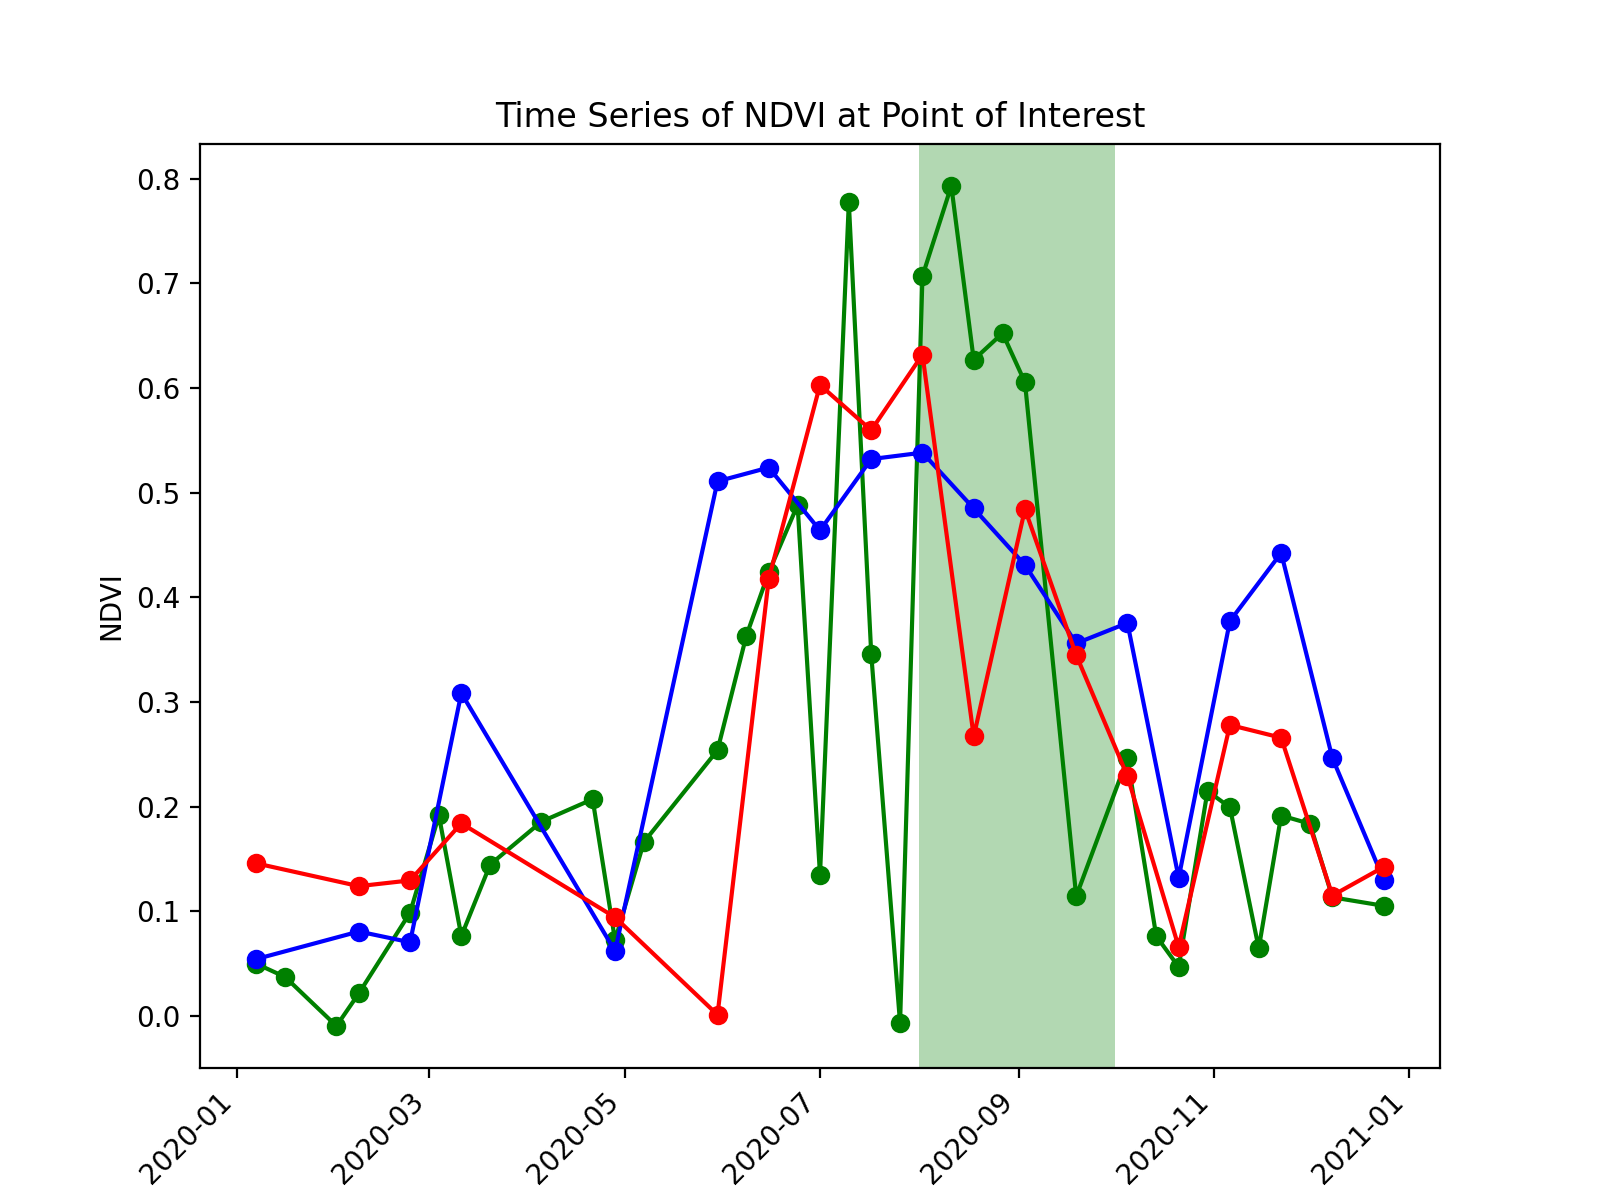

In [22]:
import matplotlib.pyplot as plt
from datetime import datetime 


def make_datetime(d):
    date_objects = [datetime.strptime(dt, '%Y-%m-%d') for dt in d]
    return date_objects

plt.figure(figsize=(8,6))


plt.plot(make_datetime(dfmsorted['dates'].values),dfmsorted['medians'],marker='o',linestyle='-',color='g')
plt.plot(make_datetime(dfsorted['dates'].values), dfsorted['ndvi_values'], marker='o', linestyle='-', color='b')
plt.plot(make_datetime(df2sorted['dates'].values), df2sorted['ndvi_values'], marker='o', linestyle='-', color='r')
plt.axvspan('2020-08-01', '2020-10-01', facecolor='g', alpha=0.3, label='Harvest season')

# Configure date formatting for the x-axis

#plt.plot(dates2, ndvi_values2, marker='o', linestyle='-', color='r')

plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('Time Series of NDVI at Point of Interest')


plt.xticks(rotation=45, ha='right')
plt.show()

So we see that we can directly use the medians calculated for each image's NDVI band instead of the 


In [31]:

enlarged_iowa_bbox = ee.Geometry.Point(centroid_coords)

soil_collection = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007").filterBounds(enlarged_iowa_bbox)\
                                            .filterDate(start_date, end_date)

In [32]:
soil_map = geemap.Map()

soil_map.addLayer(soil_collection.select('sm_surface'),{'min':0,'max':0.9},'surface moisture')